In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.neighbors import NearestNeighbors

df = pd.read_csv("../data/ETTh1.csv")
df['date'] = pd.to_datetime(df['date'])

X_elec = Normalizer().fit_transform(df[['HUFL','MUFL','LUFL']])    # Here direction matters
X_therm = 0.5 * StandardScaler().fit_transform(df[['OT']])         # Here magnitude matters

X = np.hstack([X_elec, X_therm])


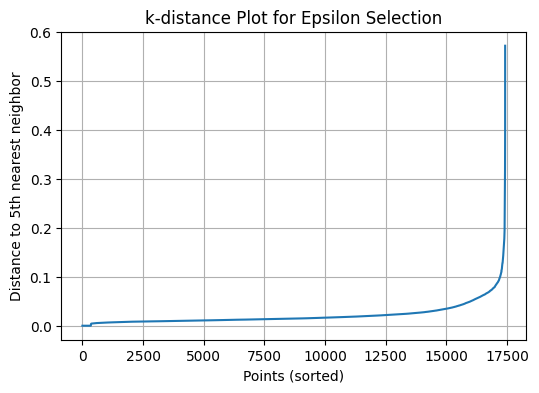

In [2]:
# We are trying to find the ideal value of epsilon in this block of code.

k = 5
nbrs = NearestNeighbors(n_neighbors=k)
nbrs.fit(X)

distances, _ = nbrs.kneighbors(X)

k_distances = np.sort(distances[:, k-1])

plt.figure(figsize=(6,4))
plt.plot(k_distances)
plt.xlabel("Points (sorted)")
plt.ylabel(f"Distance to {k}th nearest neighbor")
plt.title("k-distance Plot for Epsilon Selection")
plt.grid()
plt.show()

The elbow in the k-distance plot provides a heuristic for selecting ε.

In [3]:
# Calculating the ideal value of epsilon

x = np.arange(len(k_distances))
y = k_distances

# Line between first and last point
point1 = np.array([x[0], y[0]])
point2 = np.array([x[-1], y[-1]])

# Compute perpendicular distances
distances_to_line = np.abs(
    np.cross(point2 - point1, point1 - np.vstack((x, y)).T)
) / np.linalg.norm(point2 - point1)

# Elbow index
elbow_index = np.argmax(distances_to_line)
eps_optimal = k_distances[elbow_index]

print(eps_optimal)

0.0694429087103335


In [4]:
clustering = DBSCAN(eps=eps_optimal, min_samples=5, metric = 'euclidean')    # Based on the graph.
clustering.fit(X)
df['cluster'] = clustering.labels_

# Finding the number of clusters formed
unique, counts = np.unique(df['cluster'], return_counts=True)
print(dict(zip(unique, counts)))

# Number of anomalies
n_outliers = (df['cluster'] == -1).sum()
print(f"Total anomalies detected: {n_outliers}")

# Noise ratio
noise_ratio = np.mean(df['cluster'] == -1)
print('The noise ratio is: ', noise_ratio, '%')


{-1: 359, 0: 14441, 1: 49, 2: 17, 3: 7, 4: 19, 5: 2315, 6: 7, 7: 14, 8: 10, 9: 15, 10: 5, 11: 10, 12: 14, 13: 4, 14: 7, 15: 10, 16: 4, 17: 5, 18: 64, 19: 18, 20: 7, 21: 5, 22: 5, 23: 3, 24: 6}
Total anomalies detected: 359
The noise ratio is:  0.02060849598163031 %


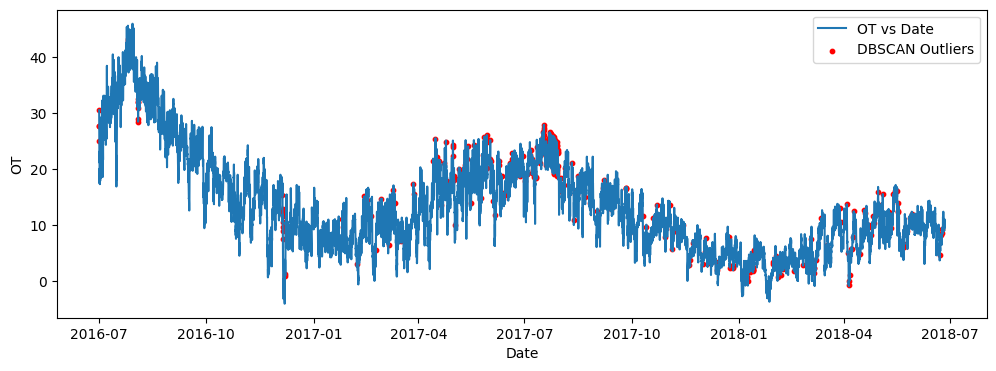

In [5]:
# Plotting the outliers
plt.figure(figsize = (12,4))
plt.plot(df['date'], df['OT'], label = 'OT vs Date')

plt.scatter(
    df.loc[df['cluster'] == -1, 'date'], df.loc[df['cluster'] == -1, 'OT'], color='red', s=10, label='DBSCAN Outliers'
)
plt.xlabel('Date')
plt.ylabel('OT')
plt.legend()
plt.show()

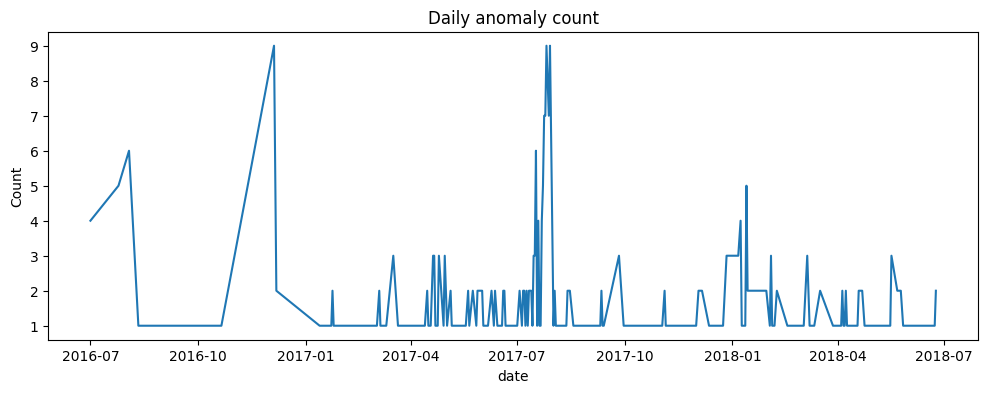

In [6]:
# Anomaly trends
daily_anomalies = df[df['cluster'] == -1].groupby(df['date'].dt.date).size()

plt.figure(figsize=(12,4))
daily_anomalies.plot()
plt.title("Daily anomaly count")
plt.ylabel("Count")
plt.show()